In [1]:
import imutils
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet import preprocess_input
import numpy as np
import argparse
import time
import cv2
import keras
from Fun_to_prepare_data import * 



In [2]:
import imutils
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [3]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [4]:
# USAGE
# python detect_with_classifier.py --image images/stingray.jpg --size "(300, 150)"
# python detect_with_classifier.py --image images/hummingbird.jpg --size "(250, 250)"
# python detect_with_classifier.py --image images/lawn_mower.jpg --size "(200, 200)" --min-conf 0.95

# import the necessary packages
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.resnet import preprocess_input
#from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.applications import imagenet_utils
#from imutils.object_detection import non_max_suppression
#from pyimagesearch.detection_helpers import sliding_window
#from pyimagesearch.detection_helpers import image_pyramid
#import numpy as np
#import argparse
#import imutils
#import time
#import cv2

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to the input image")
#ap.add_argument("-s", "--size", type=str, default="(200, 150)",
#	help="ROI size (in pixels)")
#ap.add_argument("-c", "--min-conf", type=float, default=0.9,
#	help="minimum probability to filter weak detections")
#ap.add_argument("-v", "--visualize", type=int, default=-1,
#	help="whether or not to show extra visualizations for debugging")
#args = vars(ap.parse_args())

# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = eval("350,390")
INPUT_SIZE = (64, 64)

# load our the network weights from disk
print("[INFO] loading network...")
#model = ResNet50(weights="imagenet", include_top=True)
#model = model.load_weights('../weights/model_weights')
model = keras.models.load_model('../weights/model_full')
print("[INFO] loading network... DONE")

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
image=cv2.imread("../../../../Desktop/frutilla.jpg")
orig = cv2.imread("../../../../Desktop/frutilla.jpg")
orig = imutils.resize(orig, width=WIDTH)
print(orig.shape)
(H, W) = orig.shape[:2]
print("[INFO] image already load and resize")

# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
print("[INFO] initiating the pyramid")
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
print("rois",rois)
print("locs",locs)
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

# loop over the image pyramid
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])

	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)

		# take the ROI and pre-process it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)

		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))

		# check to see if we are visualizing each of the sliding
		# windows in the image pyramid
		if 1 > 0:
			# clone the original image and then draw a bounding box
			# surrounding the current region
			clone = orig.copy()
			cv2.rectangle(clone, (x, y), (x + w, y + h),
				(0, 255, 0), 2)

			# show the visualization and current ROI
			cv2.imshow("Visualization", clone)
			cv2.imshow("ROI", roiOrig)
			cv2.waitKey(0)

# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))

# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))

# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= 0.9:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]

		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()

	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)

	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	cv2.imshow("Before", clone)
	clone = orig.copy()

	# extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# show the output after apply non-maxima suppression
	cv2.imshow("After", clone)
	cv2.waitKey(0)

[INFO] loading network...
[INFO] loading network... DONE
[INFO] image already load and resize
[INFO] initiating the pyramid
rois []
locs []
[INFO] looping over pyramid/windows took 0.00371 seconds
[INFO] classifying ROIs...


UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [5]:
def inputs(imagen):
    a=resize_image(imagen,(64,64))
    a=np.asarray(a)
    a= a.astype('float32') / 255
    return a

In [88]:
WIDTH = 1300
PYR_SCALE = 1.5
WIN_STEP = 20
ROI_SIZE = (350,390)
INPUT_SIZE = (64, 64)

In [89]:
model = keras.models.load_model('../weights/model_full')

(1390, 1300, 3)
(1390, 1300, 3)


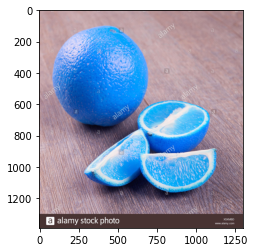

In [90]:
orig = cv2.imread("../../../../Desktop/frutilla.jpg")
plt.imshow(orig)
print(orig.shape)
orig = imutils.resize(orig, width=WIDTH)
plt.imshow(orig)
print(orig.shape)
(H, W) = orig.shape[:2]

In [91]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

In [92]:
a = next(pyramid)

In [93]:
rois = []
locs = []
start = time.time()

In [94]:
start = time.time()
for image in pyramid:
    scale = W / float(image.shape[1])
    c = sliding_window(image, WIN_STEP, ROI_SIZE)
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi= roi.astype('float32') / 255
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
    end - start))

[INFO] looping over pyramid/windows took 0.17804 seconds


In [95]:
type(rois)

list

In [96]:
rois = np.array(rois, dtype="float32")

In [97]:
type(rois)

numpy.ndarray

In [98]:
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
    end - start))

[INFO] classifying ROIs...
[INFO] classifying ROIs took 1.08798 seconds


In [103]:
preds[3]

array([0.00277036], dtype=float32)

In [113]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
    print(p)
    break


[0.00119764]


In [ ]:
    (imagenetID, label, prob) = p[0]
    
	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= 0.9:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]

		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L